In [139]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.special

In [155]:
depth_ref  = np.array([20.e3]) # m
visc_ref_crust   = 1e21
visc_ref_sed   = 1e20
d = len(depth_ref)
temp_ref = np.zeros(d)
# temp_ref   = np.array([360, 420, 602])
Tmax = 1694.; Tmin = 273.;     # min/max temperatures, K
ma=1e6*365*24*60*60;                    # subucting plate age [Ma]
age_sp=90*ma;  
k = 1e-6  

cr_yr = 0.05 #m/yr
yr = 365*24*60*60
cr = cr_yr/yr #m/s
shear_d = 2000 #m
adiabat = 0.3

strain_ref = cr/shear_d

for i in range(d):
    erf_term=(depth_ref[i])/(2*np.sqrt(k*age_sp))
    temp_ref[i]=(Tmax - (Tmax - Tmin)*scipy.special.erfc(erf_term))
    temp_ref[i] = temp_ref[i] + (depth_ref[i] * 1e-3 * adiabat)


################ sed: Violay 2012 #############
Ecrust = 482e3; Ediff = 0
Vcrust = 0;  Vdiff = 0; Vdiff_lowermant = 0
nc = 4.7;        R = 8.314
adiabat = 0.3; # K/km
Acrust = np.zeros(d)

for i in range(d):
    temp_ref[i]   = temp_ref[i] + (depth_ref[i] * 1e-3 * adiabat)
    Acrust[i] = ((2*visc_ref_crust)**(-1. * nc)) / (  strain_ref**(nc-1) * np.exp(-(Ecrust)/(R*temp_ref[i]))  )
    visc_check_crust = (1/2)*Acrust[i]**(-1/nc) * strain_ref**((1-nc)/nc) * np.exp((Ecrust)/(nc*R*temp_ref[i]))
    print(f"depth =  {depth_ref[i]/1e3}, temp = {temp_ref[i]:.2f}, Acrust = {Acrust[i]:.4E}, vsic = {visc_check_crust}")


################ SEDIMENTS: Tokle 2019 #############
Esed = 125e3; Ediff = 0
Vsed = 0;  Vdiff = 0; Vdiff_lowermant = 0
ns = 4;        R = 8.314
adiabat = 0.3; # K/km
Ased = np.zeros(d)

for i in range(d):
    temp_ref[i]   = temp_ref[i] + (depth_ref[i] * 1e-3 * adiabat)
    Ased[i] = ((2*visc_ref_sed)**(-1. * ns)) / (  strain_ref**(ns-1) * np.exp(-(Esed)/(R*temp_ref[i]))  )
    visc_check_sed = (1/2)*Ased[i]**(-1/ns) * strain_ref**((1-ns)/ns) * np.exp((Esed)/(ns*R*temp_ref[i]))
    print(f"depth =  {depth_ref[i]/1e3}, temp = {temp_ref[i]:.2f}, Ased = {Ased[i]:.4E}, vsic = {visc_check_sed}")

depth =  20.0, temp = 582.47, Acrust = 7.6629E-13, vsic = 9.999999999999978e+20
depth =  20.0, temp = 588.47, Ased = 1.5641E-34, vsic = 9.999999999999998e+19


In [156]:

##################### LITHOSPHERE/MANTLE ################

depth_ref_lith  = 330e3 # m
visc_ref   = 2.0e20
temp_ref   = 1694.5
midmantle_viscosity_jump = 25


# rheological parameters (e.g. Hirth and Kohlstedt, 2003)
Edisl = 540.e3; Ediff = 300.e3
Vdisl = 12e-6;  Vdiff = 4e-6; Vdiff_lowermant = 2.5e-6
n = 3.5;        R = 8.314
adiabat = 0.3; # K/km
temp_ref   = temp_ref + (depth_ref_lith * 1e-3 * adiabat)
press_ref  = 3300. * 9.81 * depth_ref_lith


# compute dislocation creep prefactor using:
# eta = 1/2*Aeq^(-1/n) * strain_rate^((1-n)/n) * exp((E+PV)/nRT)
# Aeq   = ((2 *eta)^(-n)) / (strain_rate^(n-1) * exp(-(E+PV)/RT))
Adisl = ((2*visc_ref)**(-1. * n)) / (  strain_ref**(n-1) * np.exp(-(Edisl+press_ref*Vdisl)/(R*temp_ref))  )
visc_check_disl = (1/2)*Adisl**(-1/n) * strain_ref**((1-n)/n) * np.exp((Edisl+press_ref*Vdisl)/(n*R*temp_ref))
print("Dislocation prefactor = %e. Check: %e = %e" % (Adisl,visc_ref,visc_check_disl))


# compute diffusion creep prefactor using:
# eta = 1/2*(1/Aeq) * exp((E+PV)/RT)
# Aeq   = (1/(2*eta)) * exp((E+PV)/RT)
Adiff = (1./(2*visc_ref)) * np.exp((Ediff+press_ref*Vdiff)/(R*temp_ref))
visc_check_diff = (1./(2*Adiff)) * np.exp((Ediff+press_ref*Vdiff)/(R*temp_ref))
print("Diffusion prefactor   = %e. Check: %e = %e" % (Adiff,visc_ref,visc_check_diff))
print("Effective upper mantle viscosity  = %e" % ((visc_check_disl * visc_check_diff)/(visc_check_disl + visc_check_diff)))


Dislocation prefactor = 4.041188e-23. Check: 2.000000e+20 = 2.000000e+20
Diffusion prefactor   = 2.399829e-11. Check: 2.000000e+20 = 2.000000e+20
Effective upper mantle viscosity  = 1.000000e+20


In [157]:
y = np.linspace(0e3,60e3, 1800)
# pl = np.zeros(len(y))
temp = np.zeros(len(y))
eta_crust = np.zeros((len(y),d))
eta_sed = np.zeros((len(y),d))
eta_diff = np.zeros(len(y))
eta_disl = np.zeros(len(y))


pl = 3300. * 9.81 * y
ps = 2700. * 9.81 * y
pc = 2900. * 9.81 * y

In [159]:

for i in range(len(y)):
    for j in range(d):
        erf_term=(y[i])/(2*np.sqrt(k*age_sp))
        temp[i]=(Tmax - (Tmax - Tmin)*scipy.special.erfc(erf_term))
        temp[i] = temp[i] + (y[i] * 1e-3 * adiabat)
        # p[i] = 2900. * 9.81 * y[i]
        eta_crust[i,j] = (1/2)*Acrust[j]**(-1/nc) * strain_ref**((1-nc)/nc) * np.exp((Ecrust)/(nc*R*temp[i]))
        eta_sed[i,j] = (1/2)*Ased[j]**(-1/ns) * strain_ref**((1-ns)/ns) * np.exp((Esed)/(ns*R*temp[i]))
        eta_disl[i] = (1/2)*Adisl**(-1/n) * strain_ref**((1-n)/n) * np.exp((Edisl+pl[i]*Vdisl)/(n*R*temp[i]))
        eta_diff[i] =  (1./(2*Adiff)) * np.exp((Ediff+pl[i]*Vdiff)/(R*temp_ref))

eta_lith = ((1/eta_diff)+(1/eta_disl))**(-1)

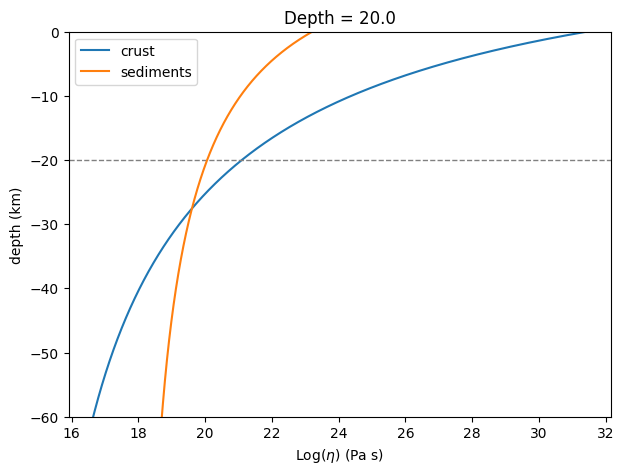

In [160]:
fig, ax = plt.subplots(1,1, figsize = (7,5))

for i in range(d):
    ax.plot(np.log10(eta_crust[:,i]), -y/1.e3, label = "crust")
    ax.axhline(y = -depth_ref[i]/1.e3, linestyle = "--", color = "grey", linewidth = 1)
    # ax[i].axvline(x = np.log10(visc_ref_crust), linestyle = "--", color = "grey", linewidth = 1)
    # ax[i].axvline(x = np.log10(visc_ref_sed), linestyle = "--", color = "grey", linewidth = 1)
    # ax.plot(np.log10(eta_disl), -y/1.e3, label = "Lithosphere")
    ax.plot(np.log10(eta_sed[:,i]), -y/1.e3, label = "sediments")
    ax.set_title(f"Depth = {depth_ref[i]/1.e3}")
    ax.set_ylim(-60,0)
ax.set_xlabel("Log($\eta$) (Pa s)")
ax.set_ylabel("depth (km)")
ax.legend()

In [216]:
######################## YIELDING: Drucker-Prager ############################
Cs = 0.e6 
Cc = 0.e6 
# Cl = 10.e6

phis = np.radians([1, 2.5, 5, 10])
phic = np.radians([1, 2.5, 5, 10])
d = len(phis)
# phil = np.radians(5)

ys = np.zeros((len(ps), d))
yc = np.zeros((len(pc), d))


for i in range(d):
    ys[:,i] = Cs*np.cos(phis[i]) + ps*np.sin(phis[i])
    yc[:,i] = Cc*np.cos(phic[i]) + pc*np.sin(phic[i])



######################## Viscous stress ############################
strain_ref = 1e-15
sigs = strain_ref*2*eta_sed
sigc = strain_ref*2*eta_crust




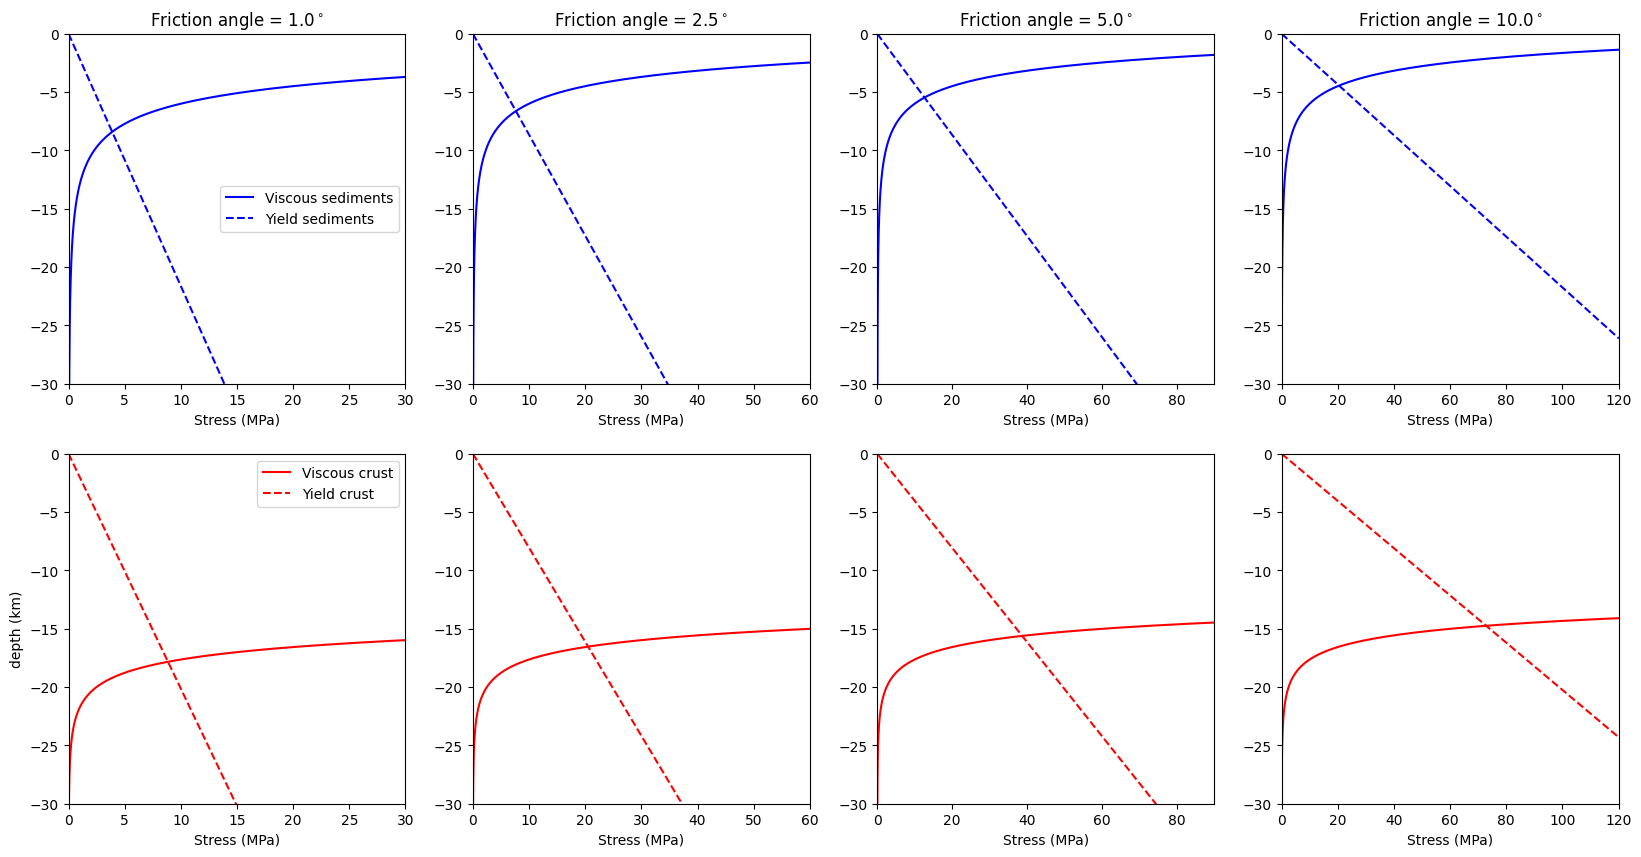

In [218]:
fig, ax = plt.subplots(2,d, figsize = (20,10))

col = ["red", "green", "blue"]

lim = 60/3

for i in range(d):
    ax[1,i].plot(sigc/1e6, -y/1.e3, label = "Viscous crust", color = col[0])
    ax[0,i].plot(sigs/1e6, -y/1.e3, label = "Viscous sediments", color = col[2])
    ax[1,i].plot(yc[:,i]/1e6, -y/1.e3, label = "Yield crust", color = col[0], linestyle = "--")
    ax[0,i].plot(ys[:,i]/1e6, -y/1.e3, label = "Yield sediments", color = col[2], linestyle = "--")
    ax[0,i].set_title(f"Friction angle = {np.rad2deg(phis[i]):.1f}$^\circ$")
    ax[1,i].set_ylim(-30,0)
    ax[1,i].set_xlim(0, (i+1)*30)
    ax[1,i].set_xlabel("Stress (MPa)")
    ax[0,i].set_xlim(0, (i+1)*30)
    ax[0,i].set_ylim(-30,0)
    ax[0,i].set_xlabel("Stress (MPa)")
ax[1,0].set_ylabel("depth (km)")
ax[1,0].legend()
ax[0,0].legend()
fig.savefig("christmas_tree.png", dpi = 1000)

In [200]:
######################## YIELDING: Drucker-Prager ############################
Cs = 0.e6 
Cc = 0.e6 


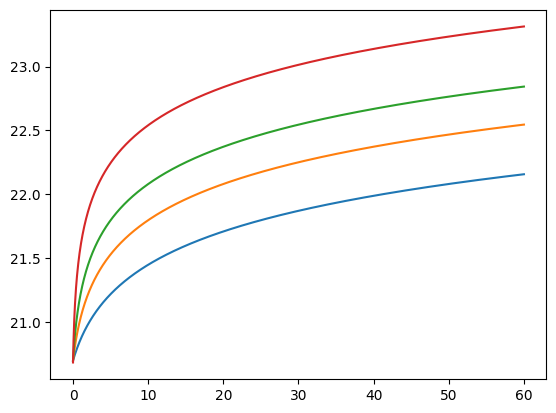

In [201]:
plt.plot(y/1e3, np.log10(ys/(2*strain_ref)))